In [18]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error

1. Get Data for a few stocks

In [19]:
stocks = ["AAPL","AMZN","GOOG","FB"]

stocks_data = {}
for fn in os.listdir('../dataset/price'):
    df = pd.read_csv('../dataset/price/'+fn)
    stocks_data[fn[:-4]] = df

2. Hyper parameters

In [7]:
layer_units, optimizer = 50, 'adam' 
cur_epochs = 15
cur_batch_size = 20
cur_LSTM_pars = {
                     'units': layer_units, 
                     'optimizer': optimizer, 
                     'batch_size': cur_batch_size, 
                     'epochs': cur_epochs
                }
scaler = StandardScaler()
    

3. Preprocessing

In [8]:
def preprocess_testdat(data, scaler, window_size, test):    
    raw = data['Close'][len(data) - len(test) - window_size:].values
    raw = raw.reshape(-1,1)
    raw = scaler.transform(raw)
    
    X_test = []
    for i in range(window_size, raw.shape[0]):
        X_test.append(raw[i-window_size:i, 0])
        
    X_test = np.array(X_test)
    
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test


def dataset_split(df):
    train, validate, test = \
              np.split(df.sample(frac=1, random_state=42),
                       [int(.6*len(df)), int(.8*len(df))])
    return train, test


def scaleDataAndModify(stock_data,train):
    def extract_seqX_outcomeY(data, N, offset):
        X, y = [], [] 
        for i in range(offset, len(data)):
            X.append(data[i-N:i])
            y.append(data[i])
        return np.array(X), np.array(y)
    scaled_data = scaler.fit_transform(stock_data[['Close']].values)
    scaled_data_train = scaled_data[:train.shape[0]]
    window_size = 50
    # We use past 50 days’ stock prices for our training to predict the 51th day's closing price.
    X_train, y_train = extract_seqX_outcomeY(scaled_data_train, window_size, window_size)
    return X_train, y_train
  

4. Run LSTM

In [9]:
### Build a LSTM model and log model summary to Neptune ###    
def Run_LSTM(X_train, layer_units=50):     
    inp = tf.keras.Input(shape=(X_train.shape[1], 1))
    
    x = LSTM(units=layer_units, return_sequences=True)(inp)
    x = LSTM(units=layer_units)(x)
    out = Dense(1, activation='linear')(x)
    model = tf.keras.Model(inp, out)
    
    # Compile the LSTM neural net
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')    
    return model   


5. Errors and plot

In [25]:
rmse_data = []
mape_data = []
mae_data = []
mse_data = []

#### Calculate the metrics RMSE and MAPE ####
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)  
    """
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))                   
    return rmse

def calculate_mape(y_true, y_pred): 
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)    
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100    
    return mape


def calculate_error_and_plot(train,test):
    rmse_lstm = calculate_rmse(np.array(test['Close']), np.array(test['Predictions_lstm']))
    print("RMSE = ", rmse_lstm)
    rmse_data.append(rmse_lstm)

    mape_lstm = calculate_mape(np.array(test['Close']), np.array(test['Predictions_lstm']))
    print("MAPE = ", mape_lstm)
    mape_data.append(mape_lstm)

    mae_val = mae(np.array(test['Close']), np.array(test['Predictions_lstm']))
    print("MAE = ", mae_val)
    mae_data.append(mae_val)

    mse_val = mean_squared_error(np.array(test['Close']), np.array(test['Predictions_lstm']))
    print("MSE = ", mse_val)
    mse_data.append(mse_val)
    
    fig = plt.figure(figsize = (20,10))
    plt.plot(train['Date'], train['Close'], label = 'Train Closing Price')
    plt.plot(test['Date'], test['Close'], label = 'Test Closing Price')
    plt.plot(test['Date'], test['Predictions_lstm'], label = 'Predicted Closing Price')
    plt.title('LSTM Model')
    plt.xlabel('Date')
    plt.ylabel('Stock Price ($)')
    plt.legend(loc="upper left")


6. Predict prices

Epoch 1/15
43/43 [==============================] - 7s 84ms/step - loss: 0.2494 - val_loss: 0.1328
Epoch 2/15
43/43 [==============================] - 3s 70ms/step - loss: 0.0658 - val_loss: 0.0418
Epoch 3/15
43/43 [==============================] - 3s 70ms/step - loss: 0.0294 - val_loss: 0.0258
Epoch 4/15
43/43 [==============================] - 3s 70ms/step - loss: 0.0172 - val_loss: 0.0236
Epoch 5/15
43/43 [==============================] - 3s 70ms/step - loss: 0.0153 - val_loss: 0.0211
Epoch 6/15
43/43 [==============================] - 3s 70ms/step - loss: 0.0149 - val_loss: 0.0196
Epoch 7/15
43/43 [==============================] - 3s 70ms/step - loss: 0.0155 - val_loss: 0.0185
Epoch 8/15
43/43 [==============================] - 3s 70ms/step - loss: 0.0165 - val_loss: 0.0176
Epoch 9/15
43/43 [==============================] - 3s 70ms/step - loss: 0.0178 - val_loss: 0.0169
Epoch 10/15
43/43 [==============================] - 3s 71ms/step - loss: 0.0191 - val_loss: 0.0163
Epoch 11/

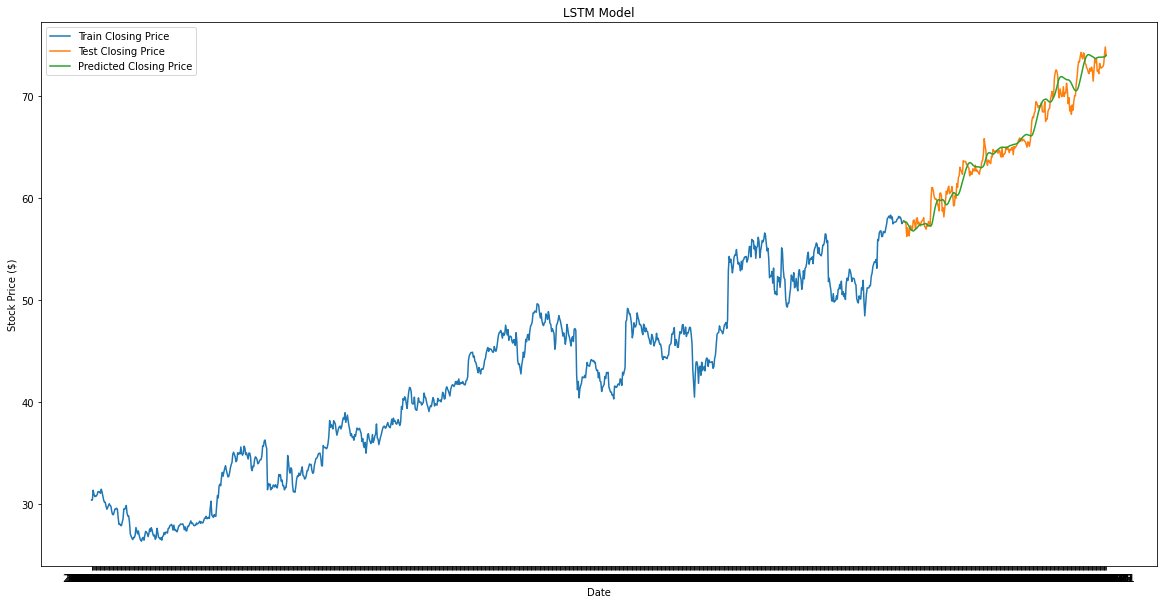

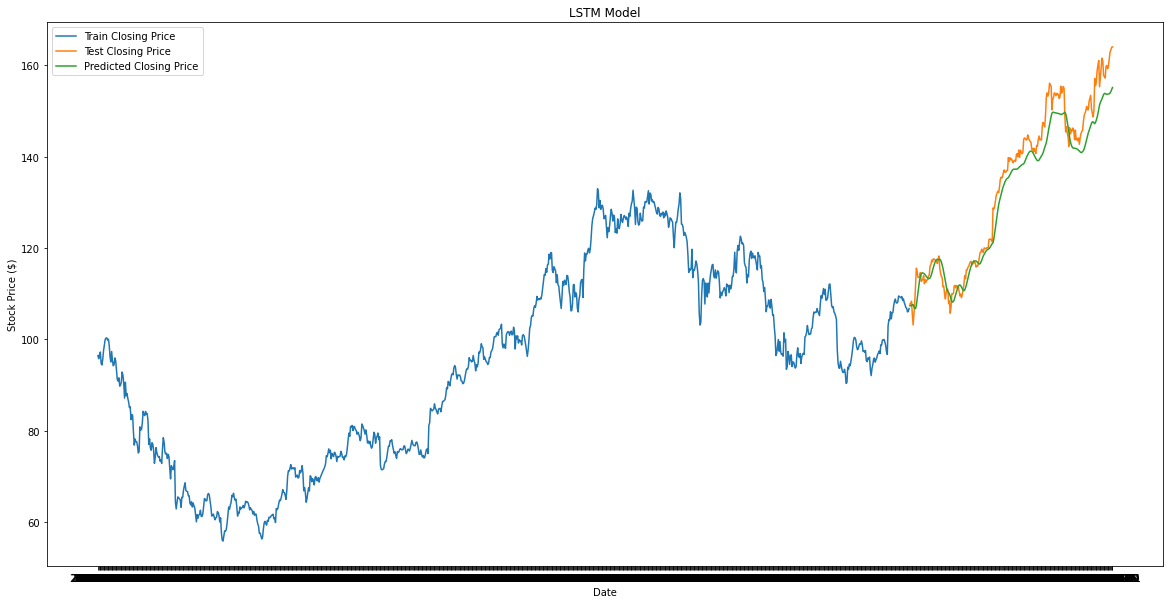

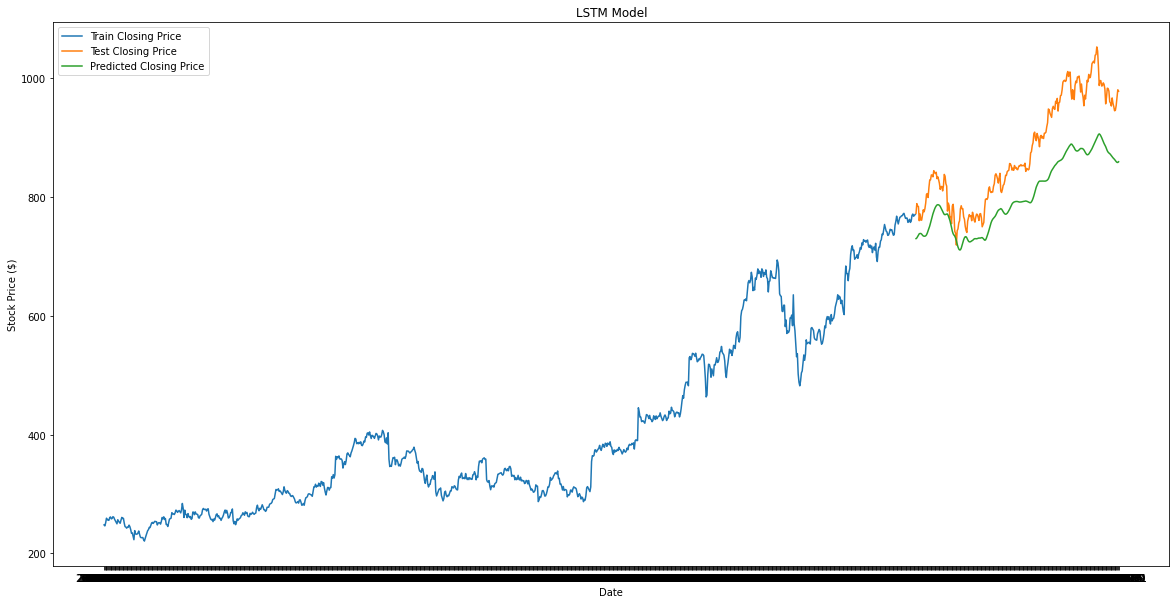

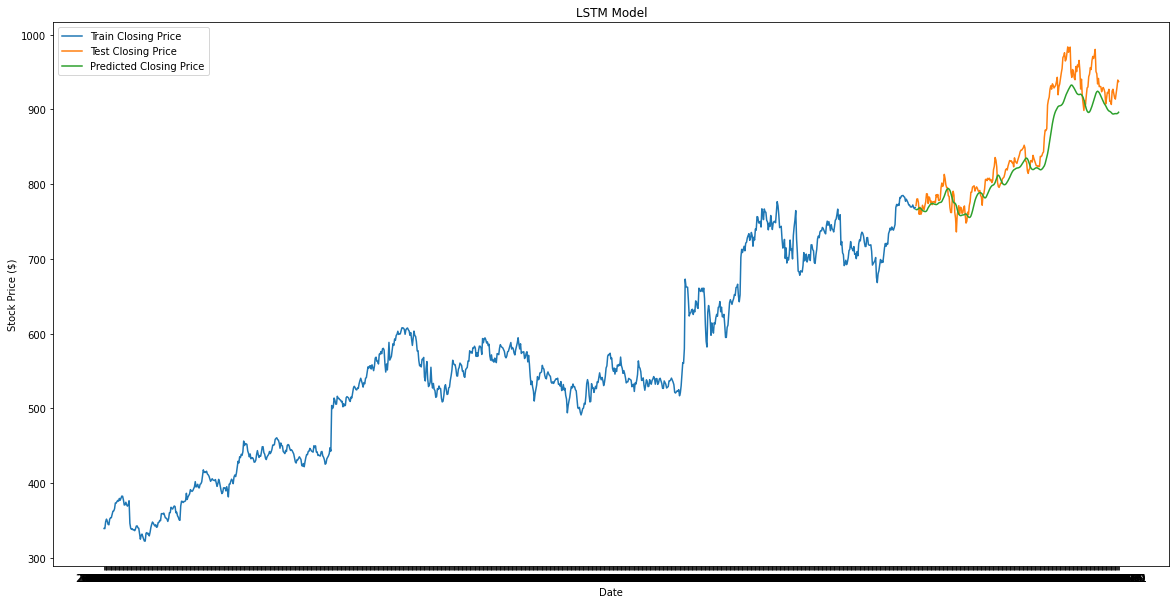

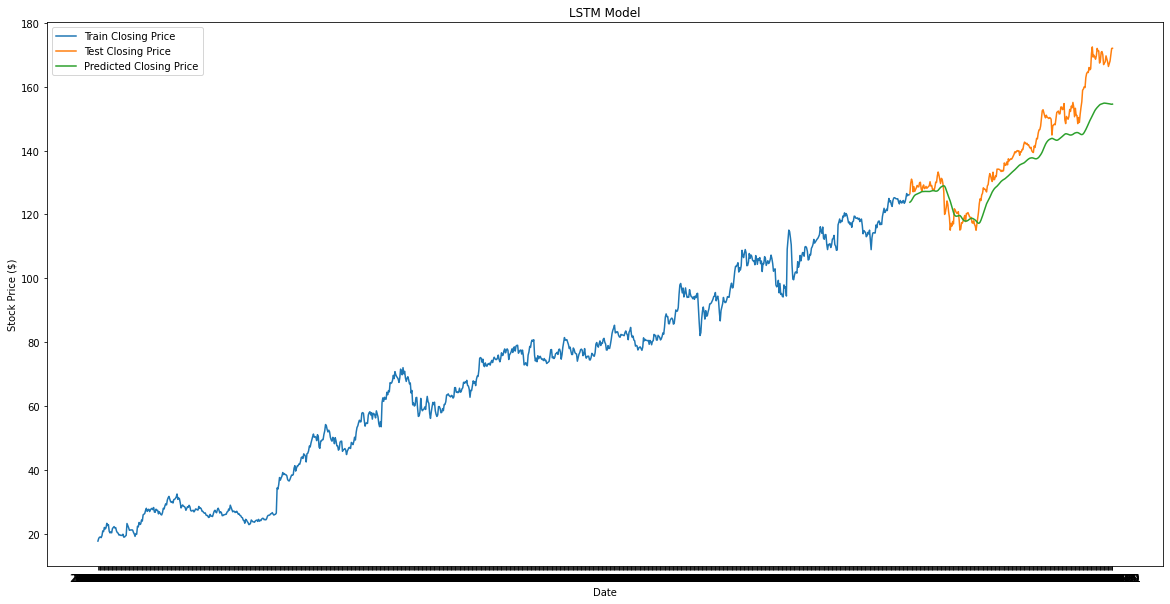

In [27]:

def predict_stocks():
  for name in stocks:
    train,test = dataset_split(stock_data[name])
    X_train, y_train = scaleDataAndModify(ticker_data[ticker],train)
    
    ## training our model
    model = Run_LSTM(X_train, layer_units = layer_units)
    history = model.fit(X_train, y_train, epochs=cur_epochs, batch_size=cur_batch_size, 
                    verbose=1, validation_split=0.1, shuffle=False)
    
    print(name, " trained successfully")
    ## preprocess test data
    X_test = preprocess_testdat(stock_data[name], scaler, 50, test)

    ##predict test data
    predicted_price_ = model.predict(X_test)
    predicted_price = scaler.inverse_transform(predicted_price_)

    # Plot predicted price vs actual closing price 
    test['Predictions_lstm'] = predicted_price
    calculate_error_and_plot(train,test)
  

predict_stocks()



In [28]:
metrics = pd.DataFrame()
metrics['RMSE'] = rmse_data
metrics['MAE'] = mae_data
metrics['MAPE'] = mape_data
metrics['MSE'] = mse_data

metrics.rename(index = {0:"AAPL"}, inplace=True)
metrics.rename(index = {1:"AMZN"}, inplace=True)
metrics.rename(index = {2:"GOOG"}, inplace=True)
metrics.rename(index = {3:"FB"}, inplace=True)
metrics


,RMSE,MAE,MAPE,MSE
MSFT,1.127839,0.881710,1.335051,1.272021
AAPL,4.125745,3.312996,2.369297,17.021771
AMZN,79.070625,71.766017,7.932021,6252.163779
GOOG,26.011349,20.138022,2.281047,676.590288
FB,7.783743,6.149214,4.146365,60.586650


**TWEET SENTIMENT ANALYSIS**

In [23]:
from bs4 import BeautifulSoup
import re
import json
import pandas as pd
from dateutil.parser import parse

**GETTING DATA**

In [24]:
tweets_path = "../dataset/tweet"
dfx = pd.DataFrame

def load_tweets(path):
  df = []
  # stocks_folders = ["MSFT","AAPL","AMZN","GOOG","FB"]
  stocks_folders = ["MSFT"]
  for folder in stocks_folders:
    try:
      stocks_files = sorted(os.listdir(f'{path}/{folder}'))
      
      for stock_file in stocks_files:
        file_path = f'{path}/{folder}/{stock_file}'
        json_file = open(file_path, 'r')
        for line in json_file.readlines():
          df_date = pd.json_normalize(json.loads(line))
          # df_date = pd.read_json(line)
          df.append(df_date)
      # dfx = pd.concat(df, sort=False)  
    except Exception as e:
      print(e)
  tweets_df = pd.concat(df,sort=False)
  return tweets_df

tweets_df = load_tweets(tweets_path)
tweets_df = tweets_df.reset_index(drop=True)
tweets_df


,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,retweeted_status.quoted_status.extended_entities.media,retweeted_status.quoted_status.favorited,retweeted_status.quoted_status.retweeted,retweeted_status.quoted_status.possibly_sensitive,retweeted_status.quoted_status.filter_level,retweeted_status.quoted_status.lang,quoted_status.is_quote_status,retweeted_status.quoted_status.user.profile_banner_url,quoted_status.quoted_status_id,quoted_status.quoted_status_id_str
0,Wed Jan 01 17:36:01 +0000 2014,418435456582561792,418435456582561792,@BenedictEvans shocking that $MSFT is missing ...,"<a href=""http://www.twitter.com"" rel=""nofollow...",False,418417512246951936,418417512246951936,1236101,1236101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Wed Jan 01 14:49:40 +0000 2014,418393593230159872,418393593230159872,RT @ACInvestorBlog: Stocks to Watch for Januar...,web,False,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Wed Jan 01 00:00:48 +0000 2014,418169902613008384,418169902613008384,Dow #Stocks Trend $AXP $UTX $CSCO $KO $HD $DIS...,"<a href=""http://12stocks.com"" rel=""nofollow"">d...",False,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Thu Jan 02 09:48:35 +0000 2014,418680211002384384,418680211002384384,Microsoft Corporation : Microsoft Assigned Pat...,"<a href=""http://ifttt.com"" rel=""nofollow"">IFTT...",False,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Thu Jan 02 06:28:12 +0000 2014,418629782884974592,418629782884974592,Corporate 'Miserliness' In The United States: ...,"<a href=""http://dlvr.it"" rel=""nofollow"">dlvr.i...",False,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,Thu Mar 31 12:12:16 +0000 2016,715512032011894785,715512032011894785,"RT $TSLA HFT Algos triggered SELL in SIGMA-X, ...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3597,Thu Mar 31 19:33:27 +0000 2016,715623059437133824,715623059437133824,RT @businessinsider: Microsoft's HoloLens has ...,"<a href=""https://about.twitter.com/products/tw...",False,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3598,Thu Mar 31 19:33:27 +0000 2016,715623059453906944,715623059453906944,RT @businessinsider: Microsoft's HoloLens has ...,"<a href=""https://about.twitter.com/products/tw...",False,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3599,Thu Mar 31 19:33:27 +0000 2016,715623059462303744,715623059462303744,RT @businessinsider: Microsoft's HoloLens has ...,"<a href=""https://about.twitter.com/products/tw...",False,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**ANALYSING USING DISTILL BERT**

In [26]:
!pip install flair
import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 401 kB 6.3 MB/s 
     |████████████████████████████████| 1.2 MB 40.0 MB/s 
     |████████████████████████████████| 1.6 MB 39.9 MB/s 
     |████████████████████████████████| 53 kB 1.5 MB/s 
     |████████████████████████████████| 101 kB 7.9 MB/s 
     |████████████████████████████████| 981 kB 53.5 MB/s 
     |████████████████████████████████| 46 kB 3.4 MB/s 
     |████████████████████████████████| 19.7 MB 1.2 MB/s 
     |████████████████████████████████| 4.7 MB 36.4 MB/s 
     |████████████████████████████████| 788 kB 36.8 MB/s 
     |████████████████████████████████| 200 kB 38.5 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 6.6 MB 49.0 MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-py3-none-any.whl size=116702 sha256=134801db8b5f7ee7f66cdf38e749c5dd10b392794b01c06d177e957ee241e1c9
  Stored

2022-08-22 10:04:15,189 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpjsc_b95a


100%|██████████| 265512723/265512723 [00:16<00:00, 16029673.21B/s]

2022-08-22 10:04:32,259 copying /tmp/tmpjsc_b95a to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2022-08-22 10:04:33,310 removing temp file /tmp/tmpjsc_b95a
2022-08-22 10:04:33,349 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


**DATA CLEANING USING REGEX**

In [27]:
def clean(tweet):
  whitespace = re.compile(r"\s+")
  web_address = re.compile(r"http(s):\/\/[a-z0-9.~_\-\/]+")
  # microsoft = re.compile(r"(?i)@Microsoft(?=\b)")
  user = re.compile(r"(?i)@[a-z0-9_]+")

  # we then use the sub method to replace anything matching
  tweet = whitespace.sub(' ', tweet)
  tweet = web_address.sub('', tweet)
  # tweet = microsoft.sub('Microsoft', tweet)
  tweet = user.sub('', tweet)
  return tweet


**PREDICTION**

In [28]:
probs = []
sentiments = []

tweets = tweets_df[['created_at','id','text']]
# use regex expressions (in clean function) to clean tweets
for i in range(0,len(tweets['text'])):
  tweets['text'][i] = clean(tweets['text'][i])
 

for tweet in tweets['text'].to_list():
    # make prediction
    sentence = flair.data.Sentence(tweet)
    sentiment_model.predict(sentence)
    # extract sentiment prediction
    probs.append(sentence.labels[0].score)  # numerical score 0-1
    sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'

# # add probability and sentiment predictions to tweets dataframe
tweets['probability'] = probs
tweets['sentiment'] = sentiments
tweets

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

,created_at,id,text,probability,sentiment
0,Wed Jan 01 17:36:01 +0000 2014,418435456582561792,shocking that $MSFT is missing this opportunity,0.997026,NEGATIVE
1,Wed Jan 01 14:49:40 +0000 2014,418393593230159872,"RT : Stocks to Watch for January 2, 2014 http:...",0.855806,NEGATIVE
2,Wed Jan 01 00:00:48 +0000 2014,418169902613008384,Dow #Stocks Trend $AXP $UTX $CSCO $KO $HD $DIS...,0.537012,POSITIVE
3,Thu Jan 02 09:48:35 +0000 2014,418680211002384384,Microsoft Corporation : Microsoft Assigned Pat...,0.977688,NEGATIVE
4,Thu Jan 02 06:28:12 +0000 2014,418629782884974592,Corporate 'Miserliness' In The United States: ...,0.997019,NEGATIVE
...,...,...,...,...,...
3596,Thu Mar 31 12:12:16 +0000 2016,715512032011894785,"RT $TSLA HFT Algos triggered SELL in SIGMA-X, ...",0.924857,POSITIVE
3597,Thu Mar 31 19:33:27 +0000 2016,715623059437133824,RT : Microsoft's HoloLens has a surprising hea...,0.785593,NEGATIVE
3598,Thu Mar 31 19:33:27 +0000 2016,715623059453906944,RT : Microsoft's HoloLens has a surprising hea...,0.785593,NEGATIVE
3599,Thu Mar 31 19:33:27 +0000 2016,715623059462303744,RT : Microsoft's HoloLens has a surprising hea...,0.785593,NEGATIVE


**CONVERTING DATA FOR ACCURACY ANALYSIS**

In [45]:
tweets['Date']=[pd.to_datetime(parse(x)).to_pydatetime().date() for x in tweets['created_at']]
tweets_data = tweets
tweets_data = tweets_data.groupby(['Date'])['sentiment'].apply(pd.Series.mode).reset_index()
tweets_data.drop(['level_1'], axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,sentiment
0,2014-01-01,NEGATIVE
1,2014-01-02,NEGATIVE
2,2014-01-03,NEGATIVE
3,2014-01-04,POSITIVE
4,2014-01-05,NEGATIVE
...,...,...
799,2016-03-27,NEGATIVE
800,2016-03-28,NEGATIVE
801,2016-03-29,NEGATIVE
802,2016-03-30,POSITIVE


**GETTING STOCK PRICE FOR SENTIMENT RANGE**

In [31]:
!pip install yfinance
import yfinance as yf
start_date = tweets_data['Date'][0].strftime('%Y-%m-%d')
end_date = tweets_data['Date'][len(tweets_data)-1].strftime('%Y-%m-%d')
msft = yf.Ticker("MSFT")
msft_stock = msft.history(
    start=start_date,
    end=end_date,
).reset_index()
msft_stock["change"] = msft_stock['Close'].pct_change().dropna()
msft_stock

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,change
0,2014-01-02,31.819109,31.861707,31.606129,31.657246,30632200,0.0,0,NaN
1,2014-01-03,31.691305,31.708344,31.180153,31.444248,31134800,0.0,0,-0.006728
2,2014-01-06,31.393138,31.427216,30.762722,30.779760,43603700,0.0,0,-0.021132
3,2014-01-07,30.950159,31.086465,30.847926,31.018311,35802800,0.0,0,0.007750
4,2014-01-08,30.669017,30.788285,30.311214,30.464556,59971700,0.0,0,-0.017853
...,...,...,...,...,...,...,...,...,...
559,2016-03-23,48.998084,49.115804,48.663040,48.871311,20129000,0.0,0,-0.001849
560,2016-03-24,48.753590,49.197300,48.653982,49.088634,19950000,0.0,0,0.004447
561,2016-03-28,49.088643,49.161087,48.291781,48.481941,17025100,0.0,0,-0.012359
562,2016-03-29,48.590598,49.677231,48.400438,49.541401,23924300,0.0,0,0.021853


**MAKING ORIGINAL DATA**

In [46]:
tweets_data['Original']=""
tweets_data['Price']=""
indx=0
for i in range (0,len(tweets_data)):
    for j in range (0,len(msft_stock)):
        get_tweet_date=tweets_data['Date'][i]
        get_stock_date=msft_stock['Date'][j]
        if(get_stock_date==get_tweet_date):
            tweets_data['Price'][i]=msft_stock['Close'][j]
            #print(get_stock_date," ",get_tweet_date)
            if msft_stock['change'][j]<0:
              tweets_data['Original'][i]="NEGATIVE"
            else:
              tweets_data['Original'][i]="POSITIVE"
            break

tweets_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: 

,Date,level_1,sentiment,Original,Price
0,2014-01-01,0,NEGATIVE,,
1,2014-01-02,0,NEGATIVE,POSITIVE,31.657246
2,2014-01-03,0,NEGATIVE,NEGATIVE,31.444248
3,2014-01-04,0,POSITIVE,,
4,2014-01-05,0,NEGATIVE,,
...,...,...,...,...,...
799,2016-03-27,0,NEGATIVE,,
800,2016-03-28,0,NEGATIVE,NEGATIVE,48.481941
801,2016-03-29,0,NEGATIVE,POSITIVE,49.541401
802,2016-03-30,0,POSITIVE,POSITIVE,49.849274


**CLEANING OF DATA ( Removing Weekends )**

In [61]:
tweets_data['sentiment'].replace('', np.nan, inplace=True)
tweets_data['Original'].replace('', np.nan, inplace=True)
tweets_data.dropna(subset=['sentiment'], inplace=True)
tweets_data.dropna(subset=['Original'], inplace=True)
tweets_data.dropna(subset=['Price'], inplace=True)

**CALCULATING ACCURACY, RECALL AND PRECISION**

In [48]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,accuracy_score
confusion_matr = confusion_matrix(tweets_data['Original'],tweets_data['sentiment'])
tweets_data['sentiment'] = tweets_data['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': 0}).astype(int)
tweets_data['Original'] = tweets_data['Original'].map({'POSITIVE': 1, 'NEGATIVE': 0}).astype(int)
precision = precision_score( tweets_data['Original'],tweets_data['sentiment'])
recall = recall_score( tweets_data['Original'],tweets_data['sentiment'])
accuracy = accuracy_score( tweets_data['Original'],tweets_data['sentiment'])
print(confusion_matr,precision,recall,accuracy)

[[216  62]
 [209  92]] 0.5974025974025974 0.30564784053156147 0.531951640759931


In [49]:
train,test = divideIntoTrainAndTest(ticker_data['MSFT'])
X_train,y_train = scaleDataAndModify(ticker_data['MSFT'],train)

   
## training our model
model = Run_LSTM(X_train,layer_units = layer_units)
history = model.fit(X_train, y_train, epochs=cur_epochs, batch_size=cur_batch_size, 
                    verbose=1, validation_split=0.1, shuffle=True)
    

    ## preprocess test data
# X_test = preprocess_testdat(ticker_data['MSFT'],scaler,50,test)


  

Epoch 1/15
43/43 [==============================] - 11s 180ms/step - loss: 0.1002 - val_loss: 0.0225
Epoch 2/15
43/43 [==============================] - 6s 139ms/step - loss: 0.0126 - val_loss: 0.0243
Epoch 3/15
43/43 [==============================] - 4s 99ms/step - loss: 0.0114 - val_loss: 0.0188
Epoch 4/15
43/43 [==============================] - 3s 75ms/step - loss: 0.0104 - val_loss: 0.0194
Epoch 5/15
43/43 [==============================] - 3s 76ms/step - loss: 0.0099 - val_loss: 0.0175
Epoch 6/15
43/43 [==============================] - 3s 72ms/step - loss: 0.0093 - val_loss: 0.0147
Epoch 7/15
43/43 [==============================] - 3s 70ms/step - loss: 0.0092 - val_loss: 0.0161
Epoch 8/15
43/43 [==============================] - 3s 72ms/step - loss: 0.0088 - val_loss: 0.0134
Epoch 9/15
43/43 [==============================] - 3s 76ms/step - loss: 0.0083 - val_loss: 0.0142
Epoch 10/15
43/43 [==============================] - 3s 72ms/step - loss: 0.0081 - val_loss: 0.0137
Epoch 

In [83]:

X_test, Y_test = extract_seqX_outcomeY(tweets_data['Price'], 50, 50)
# X_test = np.array(X_test)    
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# predicted_price_ = model.predict(X_test)
# predicted_price = scaler.inverse_transform(predicted_price_)



In [77]:
X_test

array([[31.657245635986328, 31.44424819946289, 30.779760360717773, ...,
        32.63277053833008, 32.52119064331055, 32.35810470581055],
       [31.44424819946289, 30.779760360717773, 31.018310546875, ...,
        32.52119064331055, 32.35810470581055, 32.65851593017578],
       [30.779760360717773, 31.018310546875, 30.464555740356445, ...,
        32.35810470581055, 32.65851593017578, 33.94597244262695],
       ...,
       [46.05047607421875, 46.05047607421875, 46.80569839477539, ...,
        48.96185302734375, 48.87131118774414, 49.0886344909668],
       [46.05047607421875, 46.80569839477539, 49.52988052368164, ...,
        48.87131118774414, 49.0886344909668, 48.48194122314453],
       [46.80569839477539, 49.52988052368164, 49.52988052368164, ...,
        49.0886344909668, 48.48194122314453, 49.54140090942383]],
      dtype=object)

In [69]:
tweets_data=tweets_data.reset_index()

In [68]:
tweets_data

,Date,level_1,sentiment,Original,Price
1,2014-01-02,0,0,1,31.657246
2,2014-01-03,0,0,0,31.444248
5,2014-01-06,0,0,0,30.77976
6,2014-01-07,0,0,1,31.018311
7,2014-01-08,0,0,0,30.464556
...,...,...,...,...,...
795,2016-03-23,0,0,0,48.871311
796,2016-03-24,0,0,1,49.088634
800,2016-03-28,0,0,0,48.481941
801,2016-03-29,0,0,1,49.541401
